## Import libraries

In [143]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
import optuna

## Import data

In [216]:
insp = pd.read_csv("inspections.csv")
network = pd.read_csv("network.csv")
samplesub = pd.read_csv("sample_submission.csv")

In [145]:
insp

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0
1,188889914,ZRV-00001406,2010,2010-10-01,22,4,0
2,188889907,ZRV-00001406,2010,2010-10-01,22,4,0
3,188673355,ZRV-00001406,2010,2010-10-01,22,4,0
4,188558922,ZRV-00001406,2010,2010-10-01,22,4,0
...,...,...,...,...,...,...,...
6345339,280560178,ZRV-00002112,2021,2020-12-31,23,4,0
6345340,274990683,ZRV-00002112,2021,2020-12-31,23,4,0
6345341,280560172,ZRV-00002112,2021,2020-12-31,23,4,0
6345342,274990921,ZRV-00002112,2021,2020-12-31,23,4,0


## Creating extra columns in insp df

## Filtering insp

In [146]:
filtered_df = insp[insp['Incidence'] == 1]


In [147]:
filtered_df

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
2576,11025878,ZRV-00003733,2010,2010-10-02,21,3,1
2829,11024964,ZRV-00003733,2010,2010-10-02,22,3,1
2833,10986110,ZRV-00003733,2010,2010-10-02,22,3,1
2863,100671918,ZRV-00003733,2010,2010-10-02,22,3,1
2873,11027344,ZRV-00003733,2010,2010-10-03,21,2,1
...,...,...,...,...,...,...,...
6343138,185719789,ZRV-00003663,2020,2020-12-23,24,1,1
6343194,191537870,ZRV-00002166,2020,2020-12-24,24,3,1
6344018,14242403,ZRV-00003784,2021,2020-12-29,21,2,1
6344019,419428793,ZRV-00003784,2021,2020-12-29,21,3,1


In [148]:
latest_year_index = filtered_df.groupby('PipeId')['InspectionYear'].idxmax()
filtered_df = filtered_df.loc[latest_year_index]

In [149]:
filtered_df

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
5042238,497136,ZRV-00004004,2019,2019-01-25,24,3,1
956475,510311,ZRV-00004575,2012,2012-06-21,17,3,1
829585,586278,ZRV-00003669,2012,2012-05-01,19,1,1
166907,634981,ZRV-00003838,2011,2011-02-16,21,3,1
1624648,644491,ZRV-00003997,2013,2013-07-30,24,3,1
...,...,...,...,...,...,...,...
4592473,450432110,ZRV-00003440,2018,2018-05-04,9,3,1
6006846,450854018,ZRV-00004219,2020,2020-06-05,22,3,1
619171,450872858,ZRV-00003745,2011,2011-12-21,21,3,1
738224,450873154,ZRV-00003748,2012,2012-03-05,2,3,1


In [150]:
filtered_df_ceros = insp[insp['Incidence'] == 0]


In [151]:
latest_year_index = filtered_df_ceros.groupby('PipeId')['InspectionYear'].idxmax()
filtered_df_ceros = filtered_df_ceros.loc[latest_year_index]

In [152]:
insp_final = pd.concat([filtered_df,filtered_df_ceros])

In [153]:
insp_final.Incidence.value_counts()

0    1426859
1      11471
Name: Incidence, dtype: int64

In [154]:
insp_final

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
5042238,497136,ZRV-00004004,2019,2019-01-25,24,3,1
956475,510311,ZRV-00004575,2012,2012-06-21,17,3,1
829585,586278,ZRV-00003669,2012,2012-05-01,19,1,1
166907,634981,ZRV-00003838,2011,2011-02-16,21,3,1
1624648,644491,ZRV-00003997,2013,2013-07-30,24,3,1
...,...,...,...,...,...,...,...
4998999,451195430,ZRV-00004004,2019,2019-01-03,24,4,0
4998465,451195580,ZRV-00004004,2019,2019-01-02,24,4,0
5600125,451995254,ZRV-00001573,2019,2019-10-24,48,4,0
5597386,451995260,ZRV-00001573,2019,2019-10-23,24,4,0


In [155]:
insp_final = insp_final.drop(columns=("MaintenanceId"),axis=1)

In [156]:
insp_final

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
5042238,497136,2019,2019-01-25,24,3,1
956475,510311,2012,2012-06-21,17,3,1
829585,586278,2012,2012-05-01,19,1,1
166907,634981,2011,2011-02-16,21,3,1
1624648,644491,2013,2013-07-30,24,3,1
...,...,...,...,...,...,...
4998999,451195430,2019,2019-01-03,24,4,0
4998465,451195580,2019,2019-01-02,24,4,0
5600125,451995254,2019,2019-10-24,48,4,0
5597386,451995260,2019,2019-10-23,24,4,0


## Network

In [157]:
df = pd.get_dummies(network['Province'])

# join the encoded dataframe with original dataframe
network = network.join(df)

df1 = pd.get_dummies(network['GasType'])

# join the encoded dataframe with original dataframe
network = network.join(df1)

df2 = pd.get_dummies(network['BoolBridle'])

# join the encoded dataframe with original dataframe
network = network.join(df2)

df3 = pd.get_dummies(network['Material'])

# join the encoded dataframe with original dataframe
network = network.join(df3)

network = network.drop(columns=['GasType', 'BoolBridle', 'Material',"Province","Town"])

In [158]:
insp_final.PipeId

5042238       497136
956475        510311
829585        586278
166907        634981
1624648       644491
             ...    
4998999    451195430
4998465    451195580
5600125    451995254
5597386    451995260
5602785    451995309
Name: PipeId, Length: 1438330, dtype: int64

## Data

In [159]:
network

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,Albacete,Alicante,Almeria,...,CU,FD,FG,FI,FO,PA,PE,PN,PV,ZD
0,489616,2012,63.0,7.792,0.4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,489645,2012,90.0,2.080,0.4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,489646,2012,90.0,111.173,0.4,3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,519950,2012,200.0,14.304,0.4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1332439,2012,160.0,22.669,0.4,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446534,416536087,2011,50.8,0.454,45.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1446535,416536416,2011,101.6,0.478,45.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1446536,416536438,2011,101.6,0.485,45.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1446537,416536460,2011,50.8,0.210,45.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
network.PipeId.nunique()

1446539

In [161]:
data = insp_final.merge(network, how='right', on='PipeId')

In [162]:
df1 = data[(data.duplicated(subset=['PipeId'], keep=False)) & (data['Incidence'] == 1)]

# Select rows where PipeId is not repeated
df2 = data[~data.duplicated(subset=['PipeId'], keep=False)]

# Concatenate the two DataFrames
data = pd.concat([df1, df2], ignore_index=True)

In [163]:
data = data.drop(columns=["InspectionDate","Severity"])

In [164]:
data

,PipeId,InspectionYear,MonthsLastRev,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,...,CU,FD,FG,FI,FO,PA,PE,PN,PV,ZD
0,35790261,2018.0,9.0,1.0,2016,32.0,87.826000,0.15,12,0,...,0,0,0,0,0,0,1,0,0,0
1,3663205,2013.0,16.0,1.0,2012,110.0,194.409000,0.40,8,0,...,0,0,0,0,0,0,1,0,0,0
2,228066029,2017.0,24.0,1.0,1998,200.0,171.113000,0.15,5,0,...,0,0,0,0,0,0,1,0,0,0
3,331339238,2019.0,24.0,1.0,2008,110.0,126.227181,0.15,0,0,...,0,0,0,0,0,0,1,0,0,0
4,340505207,2012.0,22.0,1.0,1998,200.0,46.319000,0.15,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446534,416536087,2013.0,0.0,0.0,2011,50.8,0.454000,45.00,0,0,...,0,0,0,0,0,0,0,0,0,0
1446535,416536416,2013.0,0.0,0.0,2011,101.6,0.478000,45.00,0,0,...,0,0,0,0,0,0,0,0,0,0
1446536,416536438,2013.0,0.0,0.0,2011,101.6,0.485000,45.00,0,0,...,0,0,0,0,0,0,0,0,0,0
1446537,416536460,2013.0,0.0,0.0,2011,50.8,0.210000,45.00,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
samplesub

,PipeId,Incidence
0,446859944,0
1,428124500,0
2,438428871,0
3,429034569,0
4,411184477,0
...,...,...
909728,235426649,0
909729,235426673,0
909730,235426707,0
909731,190956601,0


In [217]:
samplesub = samplesub.merge(data, how="inner", on="PipeId")
samplesub = samplesub.drop(columns=["Incidence_x","Incidence_y"], axis = 1)
samplesub

,PipeId,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,Albacete,...,CU,FD,FG,FI,FO,PA,PE,PN,PV,ZD
0,446859944,2019.0,23.0,2012,110.0,44.286,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,428124500,2019.0,24.0,2012,160.0,110.715,0.150,2,0,0,...,0,0,0,0,0,0,1,0,0,0
2,438428871,2019.0,23.0,2012,110.0,13.575,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,429034569,2019.0,23.0,2012,110.0,327.689,0.150,3,0,0,...,0,0,0,0,0,0,1,0,0,0
4,411184477,2019.0,23.0,2007,200.0,932.762,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891043,235426649,2020.0,24.0,2004,110.0,7.656,0.025,0,0,0,...,0,0,0,0,0,0,1,0,0,0
891044,235426673,2020.0,24.0,2004,110.0,4.383,0.025,2,0,0,...,0,0,0,0,0,0,1,0,0,0
891045,235426707,2020.0,24.0,2004,110.0,2.292,0.025,1,0,0,...,0,0,0,0,0,0,1,0,0,0
891046,190956601,2020.0,24.0,2004,90.0,87.809,4.000,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Undersampling

In [182]:
df = data.sample(frac=1)
incidence_df = data.loc[data['Incidence'] == 1]
non_incidence_df = data.loc[data['Incidence'] == 0][:11471]
normal_distributed_df = pd.concat([incidence_df, non_incidence_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df = new_df.drop(columns="PipeId",axis=1)
new_df

,InspectionYear,MonthsLastRev,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,Albacete,...,CU,FD,FG,FI,FO,PA,PE,PN,PV,ZD
13400,2020.0,24.0,0.0,2011,63.0,1.206,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9059,2017.0,18.0,1.0,2016,40.0,25.913,1.700,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2359,2016.0,24.0,1.0,2007,110.0,24.421,0.150,2,0,0,...,0,0,0,0,0,0,1,0,0,0
20093,2019.0,24.0,0.0,2001,160.0,178.146,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19579,2020.0,24.0,0.0,2007,90.0,3.908,4.000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10969,2020.0,24.0,0.0,2008,90.0,4.340,5.000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
20633,2020.0,24.0,0.0,2004,160.0,1.300,4.000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5390,2018.0,22.0,1.0,1992,250.0,33.256,0.025,2,0,0,...,0,1,0,0,0,0,0,0,0,0
860,2018.0,24.0,1.0,1999,160.0,45.624,0.025,4,0,0,...,0,0,0,0,0,0,1,0,0,0


## Model

In [206]:
data = data.dropna()

In [207]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(data.loc[:, data.columns != "Incidence"], data["Incidence"], test_size=0.1)

In [208]:
X_test_data = X_test_data.drop(columns="PipeId", axis=1)

In [209]:
X_train, X_test, y_train, y_test = train_test_split(new_df.loc[:, new_df.columns != "Incidence"], new_df["Incidence"], test_size=0.2)
from xgboost import XGBClassifier
X_full = pd.concat([X_train,X_test])
y_full = pd.concat([y_train,y_test])

In [211]:
#USING OPTUNA TO GET THE BEST PARAMS
def objective(trial):
    # Define the hyperparameters to search over
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    # Train an XGBoost classifier with the specified hyperparameters
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_full, y_full)
    
    # Calculate the auc on the test set
    y_pred = clf.predict(X_test_data)
    auc_res = roc_auc_score(y_test_data, y_pred)
    
    # Return the accuracy as the objective value for Optuna to optimize
    return auc_res


# Use Optuna to search for the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found by Optuna
print(f'Best parameters: {study.best_params}')
print(f'Best auc: {study.best_value:.3f}')

[I 2023-02-20 21:17:14,077] A new study created in memory with name: no-name-6a6e60c6-366d-459a-a830-c98b65097411
[I 2023-02-20 21:17:20,198] Trial 0 finished with value: 0.6058262567217281 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.08921038806571738, 'subsample': 0.8187048064189368, 'colsample_bytree': 0.8283186395542637, 'gamma': 4.2357661409897425, 'min_child_weight': 3}. Best is trial 0 with value: 0.6058262567217281.
[I 2023-02-20 21:17:22,843] Trial 1 finished with value: 0.7056210686555902 and parameters: {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.08674872348763518, 'subsample': 0.602823847358883, 'colsample_bytree': 0.503728686648004, 'gamma': 9.112310202639192, 'min_child_weight': 6}. Best is trial 1 with value: 0.7056210686555902.
[I 2023-02-20 21:17:31,124] Trial 2 finished with value: 0.6321981229678562 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.025472418366807668, 'subsample': 0.7895155434618331, 'c

Best parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.004988764343495616, 'subsample': 0.8108938734423243, 'colsample_bytree': 0.9951549984209278, 'gamma': 9.676918953204725, 'min_child_weight': 7}
Best auc: 0.715


In [212]:
my_model = XGBClassifier(**study.best_params)
my_model.fit(X_full, y_full)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9951549984209278, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9.676918953204725, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.004988764343495616, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

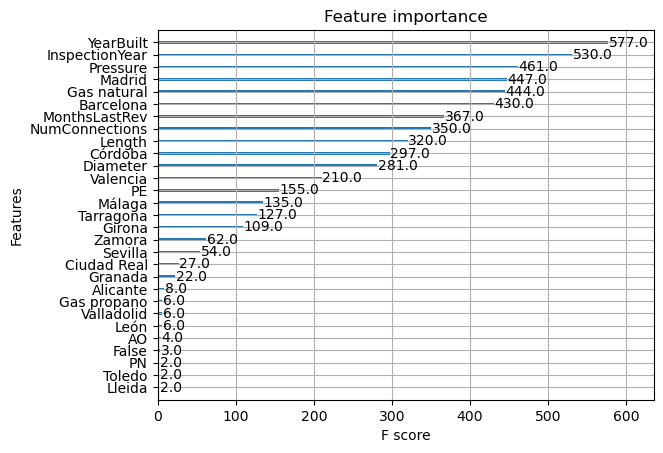

In [213]:
from xgboost import plot_importance

plot_importance(my_model)

## Predicting

In [218]:
samplesub

,PipeId,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,Albacete,...,CU,FD,FG,FI,FO,PA,PE,PN,PV,ZD
0,446859944,2019.0,23.0,2012,110.0,44.286,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,428124500,2019.0,24.0,2012,160.0,110.715,0.150,2,0,0,...,0,0,0,0,0,0,1,0,0,0
2,438428871,2019.0,23.0,2012,110.0,13.575,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,429034569,2019.0,23.0,2012,110.0,327.689,0.150,3,0,0,...,0,0,0,0,0,0,1,0,0,0
4,411184477,2019.0,23.0,2007,200.0,932.762,0.150,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891043,235426649,2020.0,24.0,2004,110.0,7.656,0.025,0,0,0,...,0,0,0,0,0,0,1,0,0,0
891044,235426673,2020.0,24.0,2004,110.0,4.383,0.025,2,0,0,...,0,0,0,0,0,0,1,0,0,0
891045,235426707,2020.0,24.0,2004,110.0,2.292,0.025,1,0,0,...,0,0,0,0,0,0,1,0,0,0
891046,190956601,2020.0,24.0,2004,90.0,87.809,4.000,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [219]:
sampleids = samplesub["PipeId"]
samplesub = samplesub.drop(columns="PipeId", axis = 1)

In [224]:
samplesub

,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,Albacete,Alicante,...,CU,FD,FG,FI,FO,PA,PE,PN,PV,ZD
0,2019.0,23.0,2012,110.0,44.286,0.150,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2019.0,24.0,2012,160.0,110.715,0.150,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2019.0,23.0,2012,110.0,13.575,0.150,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2019.0,23.0,2012,110.0,327.689,0.150,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2019.0,23.0,2007,200.0,932.762,0.150,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891043,2020.0,24.0,2004,110.0,7.656,0.025,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
891044,2020.0,24.0,2004,110.0,4.383,0.025,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
891045,2020.0,24.0,2004,110.0,2.292,0.025,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
891046,2020.0,24.0,2004,90.0,87.809,4.000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [220]:
results_1 = my_model.predict(samplesub)
results1df = pd.DataFrame(results_1)
sampleids = pd.DataFrame(sampleids)

finalfinal = sampleids.merge(results1df, left_index = True,right_index=True)
finalfinal.rename(columns={0: "Incidence"}, inplace=True)


In [221]:
finalfinal.Incidence.value_counts()

1    505821
0    385227
Name: Incidence, dtype: int64

In [223]:
finalfinal

,PipeId,Incidence
0,446859944,1
1,428124500,1
2,438428871,1
3,429034569,1
4,411184477,1
...,...,...
891043,235426649,1
891044,235426673,1
891045,235426707,1
891046,190956601,1


## Create the submission file

In [222]:
finalfinal.to_csv("SMOTE.csv", index=False)